# MLOps Datapath project
## Made by: Michael Andrés Mora P.

### Aim:

Predict share price according historical info from companies listed on Stock market.

#### Now, let's start with Data analysis info:

In [93]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
import joblib
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go

In [94]:
# Declare general variables
NAME_COMPANY = "ISA_Historical_Info.csv"
PATH_RAW = f"../data/raw/{NAME_COMPANY}"
PATH_FINAL_TRAIN = f"../data/processed/processed_training_set_{NAME_COMPANY}"
MIN_MAX_SCALER_TRANSFORMER_PATH =  "../config/model/transformers_min_max_scaler.pkl"
PATH_FINAL_TEST = f"../data/processed/processed_testing_set_{NAME_COMPANY}"


In [95]:
# Visualize the first rows of our dataset
dataset_raw = pd.read_csv(PATH_RAW, sep=',')
dataset_raw.head()


,Fecha,Último,Apertura,Máximo,Mínimo
0,13.09.2024,"16.960,00","17.020,00","17.180,00","16.960,00"
1,12.09.2024,"17.020,00","16.920,00","17.140,00","16.900,00"
2,11.09.2024,"16.840,00","17.300,00","17.460,00","16.840,00"
3,10.09.2024,"17.160,00","17.500,00","17.500,00","17.160,00"
4,09.09.2024,"17.480,00","17.180,00","17.540,00","17.180,00"


In [96]:
# Renombrar columnas específicas
dataset_raw.rename(columns={'Fecha': 'Date', 
                            'Último': 'Close', 
                            'Apertura': 'Open', 
                            'Máximo': 'High', 
                            'Mínimo': 'Low',}, inplace=True)

# Ver el resultado
print(dataset_raw)


            Date      Close       Open       High        Low
0     13.09.2024  16.960,00  17.020,00  17.180,00  16.960,00
1     12.09.2024  17.020,00  16.920,00  17.140,00  16.900,00
2     11.09.2024  16.840,00  17.300,00  17.460,00  16.840,00
3     10.09.2024  17.160,00  17.500,00  17.500,00  17.160,00
4     09.09.2024  17.480,00  17.180,00  17.540,00  17.180,00
...          ...        ...        ...        ...        ...
5366  20.08.2002   1.042,00   1.054,00   1.050,00   1.040,00
5367  16.08.2002   1.054,00   1.054,00   1.055,00   1.054,00
5368  15.08.2002   1.054,00   1.057,00   1.060,00   1.054,00
5369  14.08.2002   1.057,00   1.059,00   1.058,00   1.054,00
5370  13.08.2002   1.059,00   1.070,00   1.059,00   1.050,00

[5371 rows x 5 columns]


In [97]:
# Info about columns and type columns
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    5371 non-null   object
 1   Close   5371 non-null   object
 2   Open    5371 non-null   object
 3   High    5371 non-null   object
 4   Low     5371 non-null   object
dtypes: object(5)
memory usage: 209.9+ KB


In [98]:
# Statistical dataset info
dataset_raw.describe()

,Date,Close,Open,High,Low
count,5371,5371,5371,5371,5371
unique,5371,1594,1755,1621,1633
top,13.09.2024,"7.000,00","12.800,00","12.800,00","12.600,00"
freq,1,21,24,24,24


### Transformación de formatos:

In [99]:
# Reemplazar los puntos por guiones en la columna 'fecha'
dataset_raw['Date'] = dataset_raw['Date'].str.replace('.', '-', regex=False)

# Ver el resultado
print(dataset_raw.head(3))


         Date      Close       Open       High        Low
0  13-09-2024  16.960,00  17.020,00  17.180,00  16.960,00
1  12-09-2024  17.020,00  16.920,00  17.140,00  16.900,00
2  11-09-2024  16.840,00  17.300,00  17.460,00  16.840,00


In [100]:
# Become Date feature from object to date format
dataset_raw['Date'] = pd.to_datetime(dataset_raw['Date'], format='%d-%m-%Y')

In [101]:
# Validate this transformation
dataset_raw.head(3)

,Date,Close,Open,High,Low
0,2024-09-13,"16.960,00","17.020,00","17.180,00","16.960,00"
1,2024-09-12,"17.020,00","16.920,00","17.140,00","16.900,00"
2,2024-09-11,"16.840,00","17.300,00","17.460,00","16.840,00"


In [102]:
# Función para transformar el formato de texto a float
def transformar_a_float(valor):
    valor = valor.replace('.', '')  # Eliminar los puntos de miles
    valor = valor.replace(',', '.')  # Reemplazar la coma decimal por un punto
    return float(valor)  # Convertir a float

# Aplicar la función a la columna
dataset_raw['Open'] = dataset_raw['Open'].apply(transformar_a_float)
dataset_raw['High'] = dataset_raw['High'].apply(transformar_a_float)
dataset_raw['Low'] = dataset_raw['Low'].apply(transformar_a_float)
dataset_raw['Close'] = dataset_raw['Close'].apply(transformar_a_float)

print(dataset_raw.head(3))


        Date    Close     Open     High      Low
0 2024-09-13  16960.0  17020.0  17180.0  16960.0
1 2024-09-12  17020.0  16920.0  17140.0  16900.0
2 2024-09-11  16840.0  17300.0  17460.0  16840.0


In [103]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5371 non-null   datetime64[ns]
 1   Close   5371 non-null   float64       
 2   Open    5371 non-null   float64       
 3   High    5371 non-null   float64       
 4   Low     5371 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 209.9 KB


In [104]:
dataset_raw.describe()

,Date,Close,Open,High,Low
count,5371,5371.000000,5371.000000,5371.000000,5371.000000
mean,2013-09-03 04:47:40.696332288,10969.201825,10933.966282,11080.711413,10821.233848
min,2002-08-13 00:00:00,895.000000,895.000000,900.000000,895.000000
25%,2008-03-01 12:00:00,6990.000000,6930.000000,7025.000000,6875.000000
50%,2013-09-03 00:00:00,9980.000000,9930.000000,10020.000000,9880.000000
75%,2019-03-07 12:00:00,14500.000000,14480.000000,14660.000000,14300.000000
max,2024-09-13 00:00:00,29250.000000,29100.000000,29250.000000,28800.000000
std,NaN,6205.732635,6189.532942,6281.546560,6107.181438


In [105]:

# Crear el gráfico interactivo
fig = go.Figure()

# Añadir líneas para cada característica
fig.add_trace(go.Scatter(x=dataset_raw['Date'], y=dataset_raw['Open'], mode='lines+markers', name='Open', marker=dict(size=2)))
fig.add_trace(go.Scatter(x=dataset_raw['Date'], y=dataset_raw['High'], mode='lines+markers', name='High', marker=dict(size=2)))
fig.add_trace(go.Scatter(x=dataset_raw['Date'], y=dataset_raw['Low'], mode='lines+markers', name='Low', marker=dict(size=2)))
fig.add_trace(go.Scatter(x=dataset_raw['Date'], y=dataset_raw['Close'], mode='lines+markers', name='Close', marker=dict(size=2)))

# Personalizar el gráfico
fig.update_layout(
    title='Time series - Market value',
    xaxis_title='Date',
    yaxis_title='Prices features',
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=0,
    #template='plotly_white'
)

# Mostrar el gráfico
fig.show()


In [106]:
# Review the null values per feature
for x in (dataset_raw.columns):
    nulls_columns_x = dataset_raw[x].isnull().sum()
    print(f"Total null values to columns {x}: {nulls_columns_x}")

Total null values to columns Date: 0
Total null values to columns Close: 0
Total null values to columns Open: 0
Total null values to columns High: 0
Total null values to columns Low: 0


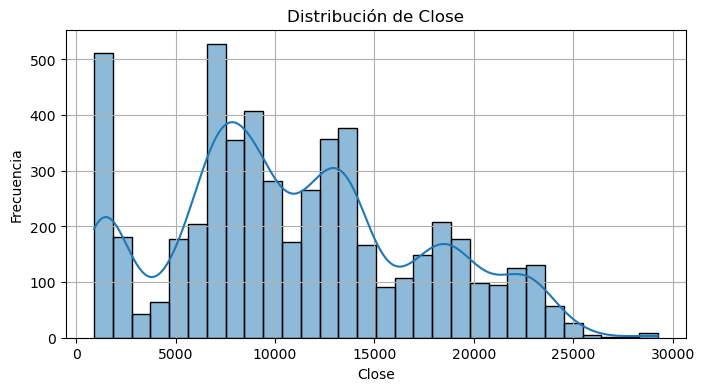

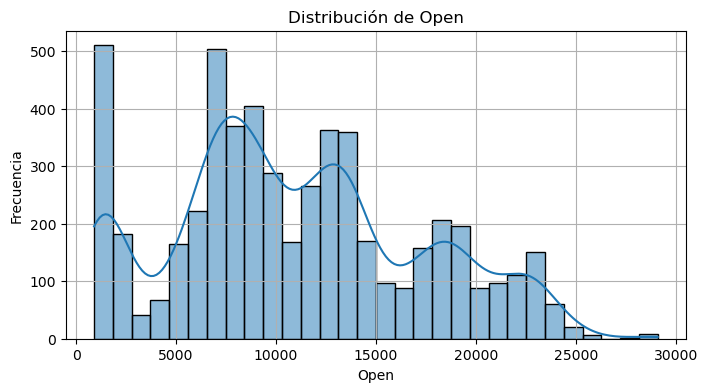

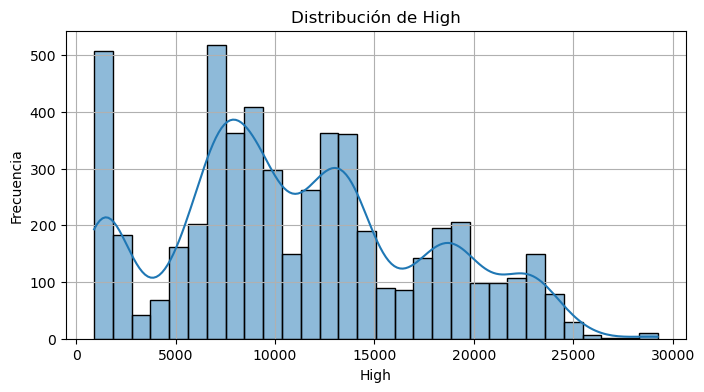

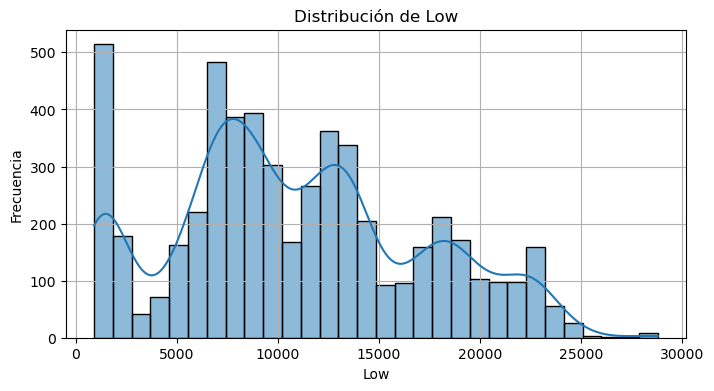

In [107]:
# Histograms per feature
for column in dataset_raw.select_dtypes(include='float64').columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset_raw[column], kde=True, bins=30)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

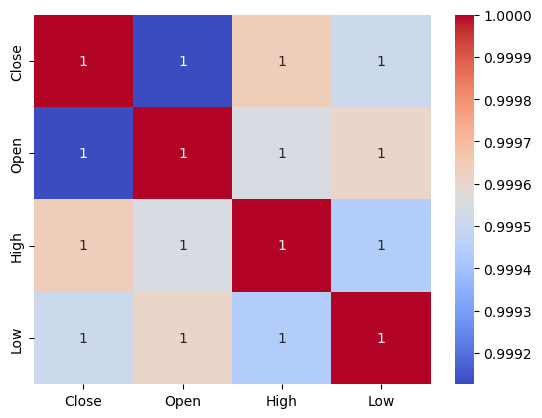

In [108]:
# Matrix correlation to prove multicolineality between features
correlation_matrix =dataset_raw.drop("Date", axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [109]:
# Filtrar datos de entrenamiento (2002-2022)
train_data = dataset_raw[(dataset_raw['Date'] >= '2002-01-01') & (dataset_raw['Date'] <= '2021-12-31')]

# Filtrar datos de prueba (2023 en adelante)
test_data = dataset_raw[dataset_raw['Date'] >= '2022-01-01']

print("Datos de entrenamiento:")
print(train_data.head())

print("\nDatos de prueba:")
print(test_data.head())


Datos de entrenamiento:
          Date    Close     Open     High      Low
657 2021-12-30  22400.0  22200.0  22500.0  22100.0
658 2021-12-29  22500.0  22310.0  22500.0  22060.0
659 2021-12-28  22400.0  22310.0  22490.0  22180.0
660 2021-12-27  22310.0  22000.0  22310.0  22000.0
661 2021-12-24  22190.0  22000.0  22200.0  22000.0

Datos de prueba:
        Date    Close     Open     High      Low
0 2024-09-13  16960.0  17020.0  17180.0  16960.0
1 2024-09-12  17020.0  16920.0  17140.0  16900.0
2 2024-09-11  16840.0  17300.0  17460.0  16840.0
3 2024-09-10  17160.0  17500.0  17500.0  17160.0
4 2024-09-09  17480.0  17180.0  17540.0  17180.0


#### Transformaciones 

In [110]:
train_data['Close']

657     22400.0
658     22500.0
659     22400.0
660     22310.0
661     22190.0
         ...   
5366     1042.0
5367     1054.0
5368     1054.0
5369     1057.0
5370     1059.0
Name: Close, Length: 4714, dtype: float64

In [111]:
# Inicializar el escalador
min_max_scaler = MinMaxScaler(feature_range=(0,1))

# Ajustar el escalador a la columna 'Close' en los datos de entrenamiento
train_data['Close'] = min_max_scaler.fit_transform(train_data[['Close']])

# Transformar la columna 'Close' en los datos de prueba
# test_data['Close'] = scaler.transform(test_data[['Close']])

print("Datos de entrenamiento con 'Close' escalado:")
print(train_data['Close'].head())

# print("\nDatos de prueba con 'Close' escalado:")
# print(test_data.head())



Datos de entrenamiento con 'Close' escalado:
657    0.758420
658    0.761947
659    0.758420
660    0.755246
661    0.751014
Name: Close, dtype: float64


/var/folders/xh/l9ggclrd1fx2brvxlnc_9hv40000gn/T/ipykernel_2924/2254218816.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



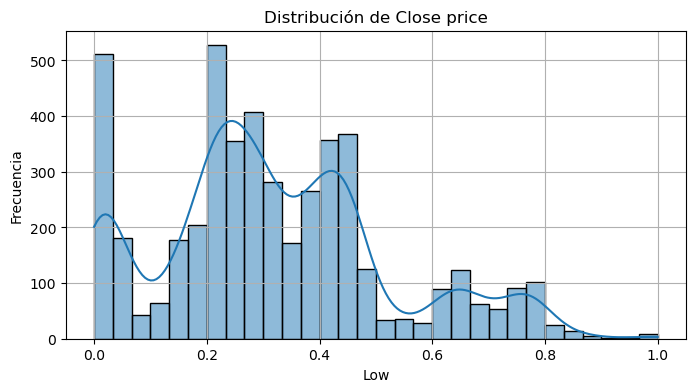

In [112]:
# Histograms per feature
plt.figure(figsize=(8, 4))
sns.histplot(train_data['Close'], kde=True, bins=30)
plt.title(f'Distribución de Close price')
plt.xlabel(column)
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [113]:
# Guardar los transformadores usando joblib
joblib.dump(min_max_scaler, MIN_MAX_SCALER_TRANSFORMER_PATH)

['../config/model/transformers_min_max_scaler.pkl']

### Save final transformed dataset

In [114]:
# Guardar el DataFrame en CSV
train_data['Close'].to_csv(PATH_FINAL_TRAIN, index=False)


#### Test data transformed and saved

In [115]:
# Ajustar el escalador a la columna 'Close' en los datos de entrenamiento
# test_data['Close'] = min_max_scaler.fit_transform(test_data[['Close']])


In [116]:
# print("Datos de testing con 'Close' escalado:")
# print(test_data['Close'].shape[0])

In [117]:
# Guardar el DataFrame en CSV
test_data['Close'].to_csv(PATH_FINAL_TEST, index=False)
